In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
PROJ_ROOT = Path().resolve().parent
DATA_DIR = PROJ_ROOT / "data" / "raw"
print("PROJ_ROOT :", PROJ_ROOT)
print("DATA_DIR :", DATA_DIR)

PROJ_ROOT : /Users/jqi/repos/intro-to-reproducible-ml
DATA_DIR : /Users/jqi/repos/intro-to-reproducible-ml/data/raw


In [3]:
def load_data(data_path):
    """Load data, sorts by time, and split by city"""
    df = pd.read_csv(data_path, index_col=[0, 1, 2]).sort_index()    
    return df.loc["sj"], df.loc["iq"]

## Training some models

Now that we've explored this data, it's time to start modeling. We will be using the scikit-learn (a.k.a. sklearn) library for machine learning. It's a mature library with a comprehensive set of tools and good documentation. It also has an opinionated design that emphasizes reuse and reproducibility through its object-oriented style and "pipeline" concepts. We highly recommend starting with scikit-learn for most machine learning situations.

We start by importing the parts of scikit-learn that we will be using.

In [4]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.model_selection import train_test_split

from sklearn.linear_model import PoissonRegressor

# For pipeline visualization
from sklearn import set_config
set_config(display='diagram') 

### Data

First, let's load the training data again so we have clean, fresh dataframes that haven't been modified. 

In [5]:
sj_features_df, iq_features_df = load_data(DATA_DIR / "dengue_features_train.csv")
sj_labels_df, iq_labels_df = load_data(DATA_DIR / "dengue_labels_train.csv")

print("sj_features_df", sj_features_df.shape)
print("iq_features_df", iq_features_df.shape)
print("sj_labels_df", sj_labels_df.shape)
print("iq_labels_df", iq_labels_df.shape)

sj_features_df (936, 21)
iq_features_df (520, 21)
sj_labels_df (936, 1)
iq_labels_df (520, 1)


Next, we'll split our data into training and evaluation. It's important when evaluating model performance to do so on data not used for training. Since we have time series data, we'll do a strict-future holdout for our evaluation. Our data is already sorted by time, so we can use sklearn's `train_test_split` function _without shuffling_.

In [6]:
sj_X_train, sj_X_eval, sj_y_train, sj_y_eval = train_test_split(
    sj_features_df,
    sj_labels_df,
    test_size=0.25,
    shuffle=False,
)

iq_X_train, iq_X_eval, iq_y_train, iq_y_eval = train_test_split(
    iq_features_df,
    iq_labels_df,
    test_size=0.25,
    shuffle=False,
)

### Data Proprocessing

Now let's define our preprocessing steps. We'll be doing two main things:
- **Scaling**: This step is not critical but often useful to generally do as a rule of thumb. In our case, scaling will help the model regularize features more effectively. It will also give us model weights that can be compared across features and interpreted as feature importances. 
- **Missing Value Imputation**: This step is necessary. Most machine learning models don't handle missing values. Because we have a time series problem, we'll use forward-fill imputation as a first pass approach, where we fill using the previous timestep's value. 

sklearn doesn't have a forward-fill imputation transformer, so we'll need to make our own. This is a good demonstration of sklearn's `FunctionTransformer` class, which you can use to implement simple functions into sklearn transformers. We define a function `forward_fill` which takes a numpy array, uses the `ffill` functionality from pandas, and then returns the data back as a numpy array.

In [7]:
def forward_fill(array):
    return pd.DataFrame(array).ffill().values

forward_imputer = FunctionTransformer(forward_fill)

Next, we'll stitch together our preprocessing steps into a preprocessor object that can be fitted and reused. We will use the `ColumnTransformer` class, which is the way sklearn expects you to pull columns out of a pandas dataframe and apply data transformations. In setting up the `ColumnTransformer`, we chain together our two preprocessing steps into one transformer using `Pipeline`, and then we set that we want to apply it to our subset of features. We will have the `ColumnTransformer` drop the remainder of the dataframe columns. 

In [8]:
features_to_use = [
    "reanalysis_specific_humidity_g_per_kg", 
    "reanalysis_dew_point_temp_k", 
    "station_avg_temp_c", 
    "station_min_temp_c"
]

preprocessing_steps = Pipeline([
    ("standard_scaler", StandardScaler()),
    ("forward_imputer", forward_imputer)
])

sj_preprocessor = ColumnTransformer(
    transformers = [
        ("features", preprocessing_steps, features_to_use)
    ],
    remainder = "drop"
)

We actually will need a second preprocessor object. This is because the scaling is fit to data, so we need one for San Juan and another for Iquitos. You'll notice we named the preprocessor we just created `sj_preprocessor`. We can use the `clone` function make a copy for `iq`. 

In [9]:
iq_preprocessor = clone(sj_preprocessor)

## Pipeline

Now we'll wrap up our full modeling workflow, including the Poisson Regression model itself, into sklearn `Pipeline` objects. We used these earlier to chain our scaling and imputation. Pipelines encapsulate everything into one object with one interface, which makes it easy to train a model, save it for later, reload it, and use it again. It's a valuable tool in making your machine learning models reusable and reproducible.

In [10]:
sj_pipeline = Pipeline([
    ("preprocessor", sj_preprocessor),
    ("estimator", PoissonRegressor())
])

iq_pipeline = Pipeline([
    ("preprocessor", iq_preprocessor),
    ("estimator", PoissonRegressor())
])

iq_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('features',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('forward_imputer',
                                                                   FunctionTransformer(func=<function forward_fill at 0x7f9f0fe9c700>))]),
                                                  ['reanalysis_specific_humidity_g_per_kg',
                                                   'reanalysis_dew_point_temp_k',
                                                   'station_avg_temp_c',
                                                   'station_min_temp_c'])])),
                ('estimator', PoissonRegressor())])

Now, let's fit our models and evaluate them!

In [11]:
sj_pipeline.fit(sj_X_train, sj_y_train)
iq_pipeline.fit(iq_X_train, iq_y_train)

sj_preds = sj_pipeline.predict(sj_X_eval)
iq_preds = iq_pipeline.predict(iq_X_eval)

/Users/jqi/miniconda3/envs/intro-to-reproducible-ml/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jqi/miniconda3/envs/intro-to-reproducible-ml/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


We'll plot the predictions against the true case counts for both models. 

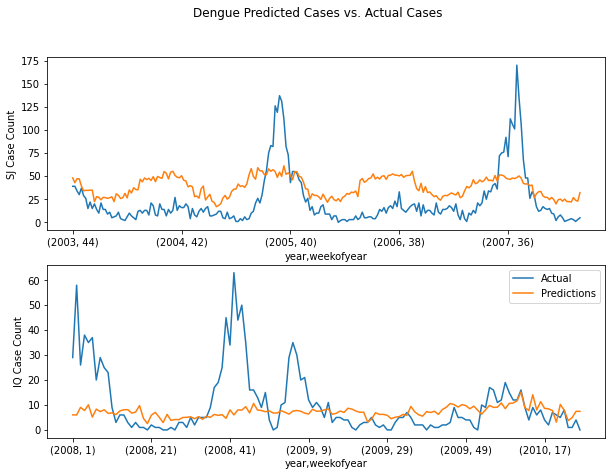

In [12]:
figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,7))

sj_y_eval.plot(ax=axes[0],legend=None)
axes[0].plot(sj_preds, label="Predictions")
axes[0].set_ylabel("SJ Case Count")

iq_y_eval.rename(columns={"total_cases": "Actual"}).plot(ax=axes[1])
axes[1].plot(iq_preds, label="Predictions")
axes[1].set_ylabel("IQ Case Count")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()
None

## Reflecting on our performance

These graphs can actually tell us a lot about where our model is going wrong and give us some good hints about where investments will improve the model performance. For example, we see that our model in orange does track the seasonality of Dengue cases. However, the timing of the seasonality of our predictions has a mismatch with the actual results. One potential reason for this is that our features don't look far enough into the past—that is to say, we are asking to predict cases at the same time as we are measuring percipitation. Because dengue is mosquito-borne, and the mosquito lifecycle depends on water, we need to take both the life of a mosquito and the time between infection and symptoms into account when modeling dengue. This is a critical avenue to explore when improving this model.

The other important error is that our predictions are relatively consistent—we miss the spikes that are large outbreaks. One reason is that we don't take into account the contagiousness of dengue. A possible way to account for this is to build a model that progressively predicts a new value while taking into account the previous prediction. By training on the dengue outbreaks and then using the predicted number of patients in the week before, we can start to model this time dependence that the current model misses.

We also know that Poisson regression is not the best suited for this dataset. We saw earlier than our variance in counts is higher than the mean, making it negative binomial regression more appropriate. While sklearn doesn't offer negative binomial regression, you could use the [statsmodel](https://www.statsmodels.org/stable/generated/statsmodels.genmod.families.family.NegativeBinomial.html) package. You can also take advantage of sklearn's extendability to wrap statsmodel's `NegativeBinomial` model inside custom sklearn estimator, so that we can plug it into our sklearn pipeline. More about custom sklearn estimators is available in their [documentation](https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator). 

So, we know we're not going to win this thing, but let's submit the predictions anyway!

### Generating a submission

First, we want to retrain our models on the full dataset.

In [13]:
sj_pipeline.fit(sj_features_df, sj_labels_df)
iq_pipeline.fit(iq_features_df, iq_labels_df)
None

/Users/jqi/miniconda3/envs/intro-to-reproducible-ml/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/jqi/miniconda3/envs/intro-to-reproducible-ml/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Now, we'll load our test data and generate predictions.

In [14]:
sj_test_df, iq_test_df = load_data(DATA_DIR / "dengue_features_test.csv")

print("sj_test_df", sj_test_df.shape)
print("iq_test_df", iq_test_df.shape)

sj_test_df (260, 21)
iq_test_df (156, 21)


In [15]:
sj_test_preds = sj_pipeline.predict(sj_test_df)
iq_test_preds = iq_pipeline.predict(iq_test_df)

Then, we'll load up the submission format and plug our predictions in. 

In [16]:
OUTPUT_DIR = PROJ_ROOT / "data" / "processed"
print("OUTPUT_DIR : ", OUTPUT_DIR)

OUTPUT_DIR :  /Users/jqi/repos/intro-to-reproducible-ml/data/processed


In [18]:
sj_submission_df, iq_submission_df = load_data(DATA_DIR / "submission_format.csv")

sj_submission_df["total_cases"] = sj_test_preds.astype(int)
iq_submission_df["total_cases"] = iq_test_preds.astype(int)

# Rejoin SJ and IQ together. 
submission_df = pd.concat({
    "sj": sj_submission_df, 
    "iq": iq_submission_df
}, names=["city"])

submission_df.to_csv(OUTPUT_DIR / "submission.csv")

submission_df.head(10)

total_cases
city year weekofyear             
sj   2008 18                   28
          19                   26
          20                   36
          21                   29
          22                   31
          23                   33
          24                   35
          25                   41
          26                   43
          27                   42